In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

In [49]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [50]:
fashion_mnist = keras.datasets.fashion_mnist

In [51]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

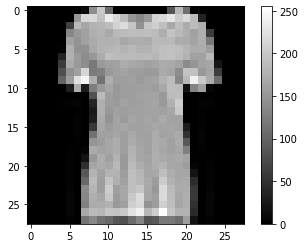

In [6]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [7]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

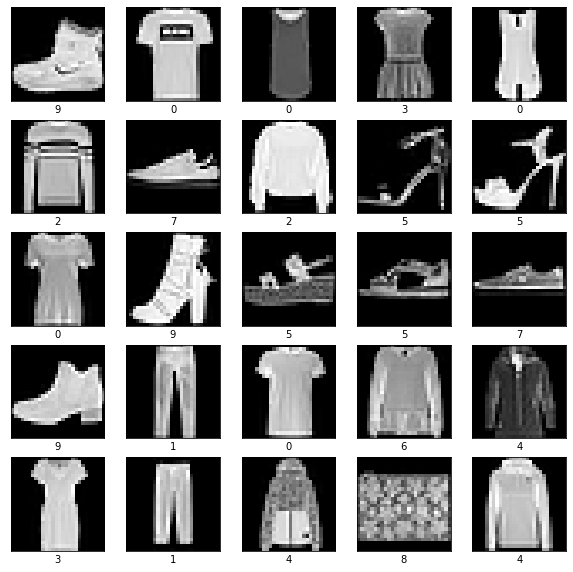

In [8]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

## Filtrando las Clases

* 1 Trouser
* 3 Dress
* 9 Ankle Boot


In [52]:
#Dataset Train

filtro = (train_labels == 1) + (train_labels == 3) + (train_labels == 9) 

In [53]:
images_filtroT = train_images[filtro]
labels_filtroT = train_labels[filtro]

## Preparando el Dataset Train

In [54]:
n = len(images_filtroT)

In [55]:
shapeT = np.shape(images_filtroT)

In [56]:
imagesT = images_filtroT.reshape((n, -1))
labelsT = labels_filtroT.reshape((n, -1))

In [57]:
#One-hot labels Train
import pandas as pd

In [58]:
pd.Series(labels_filtroT)

0        9
1        3
2        9
3        9
4        1
        ..
17995    3
17996    1
17997    1
17998    1
17999    3
Length: 18000, dtype: uint8

In [59]:
encoded = pd.get_dummies(pd.Series(labels_filtroT))

In [60]:
oneHotT = np.array(encoded)

## Preparando el Dataset Test

In [61]:
#Dataset Test

filtroTest = (test_labels == 1) + (test_labels == 3) + (test_labels == 9) 


In [62]:
images_filtroTest = test_images[filtroTest]
labels_filtroTest = test_labels[filtroTest]
n2 = len(images_filtroTest)

imagesTest = images_filtroTest.reshape((n2, -1))
labelsTest = labels_filtroTest.reshape((n2, -1))

In [63]:
#One-hot labels Test
pd.Series(labels_filtroTest)
encoded2 = pd.get_dummies(pd.Series(labels_filtroTest))
oneHotTest = np.array(encoded2)

## Modelo en Tensorflow con Datos Crudos

In [64]:
def images_predict(vector_imagen, lr, epochs, one_hot, matriz_X, matriz_test, hotTest):
    
    tf.reset_default_graph()
    g = tf.Graph()
    
    n = len(matriz_X)
    shapeT = np.shape(matriz_X)
    batch_size = 32
    total_iteraciones = int(n/batch_size)
    dic = {0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',
           4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag', 9:'Ankle boot'}
    dic2 = {0:'Trouser',1:'Dress',2:'Ankle boot'}


    with g.as_default():
   
        matriz_x = tf.placeholder(dtype=tf.float32, shape=[None,shapeT[1]], name = "matriz_x")
        matriz_w = tf.get_variable(dtype=tf.float32, initializer=tf.truncated_normal,shape=[shapeT[1],3], name = "matriz_w")
        intercepto = tf.get_variable(dtype=tf.float32, shape=[3], initializer=tf.zeros_initializer(), name="Intercepto")
        m_OneHot = tf.placeholder(dtype=tf.float32, shape=[None,3], name = "matriz_one_hot")
        m_OneHotTest = tf.placeholder(dtype=tf.float32, shape=[None,3])

    
        with tf.name_scope("Hipotesis"):
            logit = tf.matmul(matriz_x, matriz_w, name = "Logit") + intercepto
            costo = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logit, labels = m_OneHot), name = "Costo")
            scalar_costo = tf.summary.scalar('Costo Modelo RL', costo)

    
        with tf.name_scope("Gradiente"):
            gradiente = tf.gradients(costo, [matriz_w], name = "Gradient")
            gradiente2 = gradiente[0]
    

        with tf.name_scope("Parametros"):
            w_actual = tf.add(tf.multiply(gradiente2, -lr), matriz_w)
            matriz_w = matriz_w.assign(w_actual)
    
    
        prediccionT = tf.nn.softmax(logit, name = "Prediccion")
    
        with tf.name_scope("Accuracy"):
            a = tf.reshape(tf.math.argmax(prediccionT, axis = 1), shape = (1,-1))
            aa = tf.math.equal(a, 0)
            bb = labelsT.reshape(1,-1) == 1
            cc = tf.math.equal(aa, bb)
            dd = tf.count_nonzero(tf.equal(cc, True), name = "Conteo_Aciertos")
            ac = dd / n
            scalar_ac = tf.summary.scalar('Accuracy Modelo RL', ac)
        
        with tf.train.MonitoredSession() as session:
            
            writer = tf.summary.FileWriter('./graphs5', session.graph)

            for i in range(epochs):
    
                feed_dict = {matriz_x: matriz_X, m_OneHot: one_hot}
                print(session.run(costo, feed_dict = feed_dict))
                session.run(logit, feed_dict = feed_dict)
                sc = session.run(scalar_costo,feed_dict=feed_dict)
                writer.add_summary(sc, epochs+1)
                
                session.run(a, feed_dict = feed_dict)
                session.run(aa, feed_dict = feed_dict)
                session.run(ac, feed_dict = feed_dict)
                sa = session.run(scalar_ac,feed_dict=feed_dict)
                writer.add_summary(sa, epochs+1)

                
        
                for j in range(total_iteraciones):   
                    muestra_inicio = j*batch_size
                    muestra_fin = muestra_inicio + batch_size
                    X =  matriz_X[muestra_inicio:muestra_fin]
                    hot = one_hot[muestra_inicio:muestra_fin]
      
                    feed_dict2 = {matriz_x: X, m_OneHot: hot}
                    session.run(gradiente, feed_dict = feed_dict2)
                    session.run(w_actual, feed_dict = feed_dict2)
                    session.run(matriz_w, feed_dict = feed_dict2)
                    
                
                    p = session.run(prediccionT, feed_dict = feed_dict)
            
            
            feed_dict3 = {matriz_x: vector_imagen, m_OneHot: hotTest}
            session.run(costo, feed_dict = feed_dict3)
            session.run(logit, feed_dict = feed_dict3)
            predict = session.run(prediccionT, feed_dict = feed_dict3)
            num = np.argmax(predict)
            namePredict = dic2[num]
            
            
            plt.imshow(vector_imagen.reshape(28,28), cmap='gray')
            plt.xlabel(namePredict)
            plt.show()
            
            print("Accuracy:")
            print(session.run(ac, feed_dict = feed_dict))

            return(ac, predict, namePredict)
        
            

## Muestreo de 5 Prendas

INFO:tensorflow:Summary name Costo Modelo RL is illegal; using Costo_Modelo_RL instead.
INFO:tensorflow:Summary name Accuracy Modelo RL is illegal; using Accuracy_Modelo_RL instead.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
2302.7903
29.116493
23.82386
19.03687
15.744477
13.778733
13.33144
13.877109
10.219824
11.994037


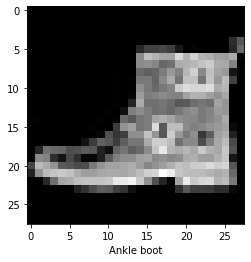

Accuracy:
0.982388888888889


(<tf.Tensor 'Accuracy/truediv:0' shape=() dtype=float64>,
 array([[0., 0., 1.]], dtype=float32),
 'Ankle boot')

In [48]:
images_predict(imagesTest[2748].reshape((1,784)), 0.001, 10, oneHotT, imagesT, imagesTest, oneHotTest)

INFO:tensorflow:Summary name Costo Modelo RL is illegal; using Costo_Modelo_RL instead.
INFO:tensorflow:Summary name Accuracy Modelo RL is illegal; using Accuracy_Modelo_RL instead.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
2199.1511
74.16005
71.19747
52.920887
47.854946


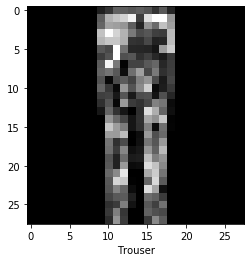

Accuracy:
0.9865555555555556


(<tf.Tensor 'Accuracy/truediv:0' shape=() dtype=float64>,
 array([[1., 0., 0.]], dtype=float32),
 'Trouser')

In [65]:
images_predict(imagesTest[2998].reshape((1,784)), 0.01, 5, oneHotT, imagesT, imagesTest, oneHotTest)

INFO:tensorflow:Summary name Costo Modelo RL is illegal; using Costo_Modelo_RL instead.
INFO:tensorflow:Summary name Accuracy Modelo RL is illegal; using Accuracy_Modelo_RL instead.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
1531.6617
63.07617
64.6344
51.57154
50.92038


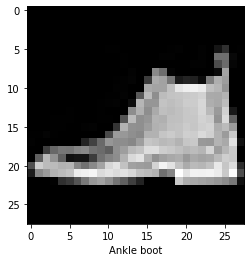

Accuracy:
0.9873333333333334


(<tf.Tensor 'Accuracy/truediv:0' shape=() dtype=float64>,
 array([[0., 0., 1.]], dtype=float32),
 'Ankle boot')

In [66]:
images_predict(imagesTest[527].reshape((1,784)), 0.01, 5, oneHotT, imagesT, imagesTest, oneHotTest)

INFO:tensorflow:Summary name Costo Modelo RL is illegal; using Costo_Modelo_RL instead.
INFO:tensorflow:Summary name Accuracy Modelo RL is illegal; using Accuracy_Modelo_RL instead.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
1396.3916
59.212563
80.30815
65.31997
57.712116


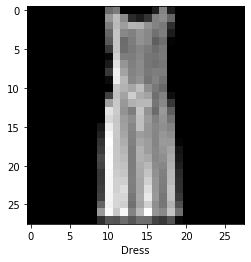

Accuracy:
0.9866666666666667


(<tf.Tensor 'Accuracy/truediv:0' shape=() dtype=float64>,
 array([[0., 1., 0.]], dtype=float32),
 'Dress')

In [67]:
images_predict(imagesTest[400].reshape((1,784)), 0.01, 5, oneHotT, imagesT, imagesTest, oneHotTest)

INFO:tensorflow:Summary name Costo Modelo RL is illegal; using Costo_Modelo_RL instead.
INFO:tensorflow:Summary name Accuracy Modelo RL is illegal; using Accuracy_Modelo_RL instead.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
1822.1638
73.62589
52.270485
65.6731
60.53528


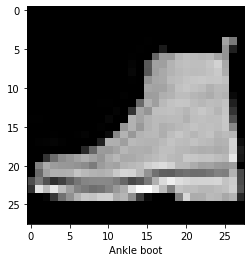

Accuracy:
0.9833333333333334


(<tf.Tensor 'Accuracy/truediv:0' shape=() dtype=float64>,
 array([[0., 0., 1.]], dtype=float32),
 'Ankle boot')

In [68]:
images_predict(imagesTest[179].reshape((1,784)), 0.01, 5, oneHotT, imagesT, imagesTest, oneHotTest)

## Tensorboard

### Grafo

In [37]:
from PIL import Image

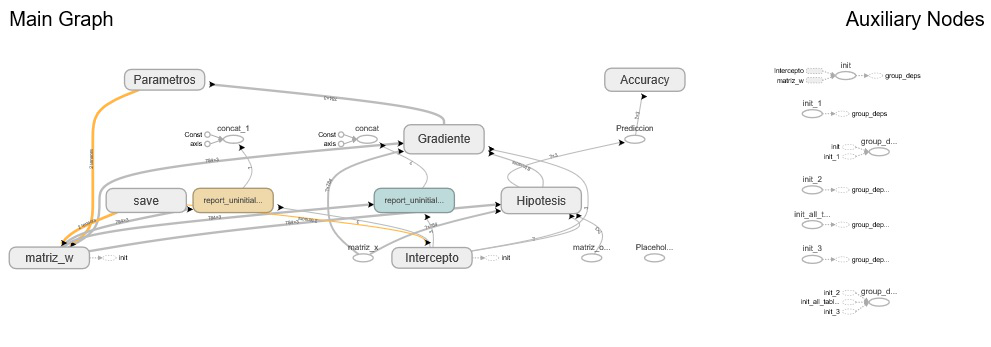

In [38]:
Image.open('Grafo 1 Tarea 4 RL.jpg','r') 

### Scalar Accuracy

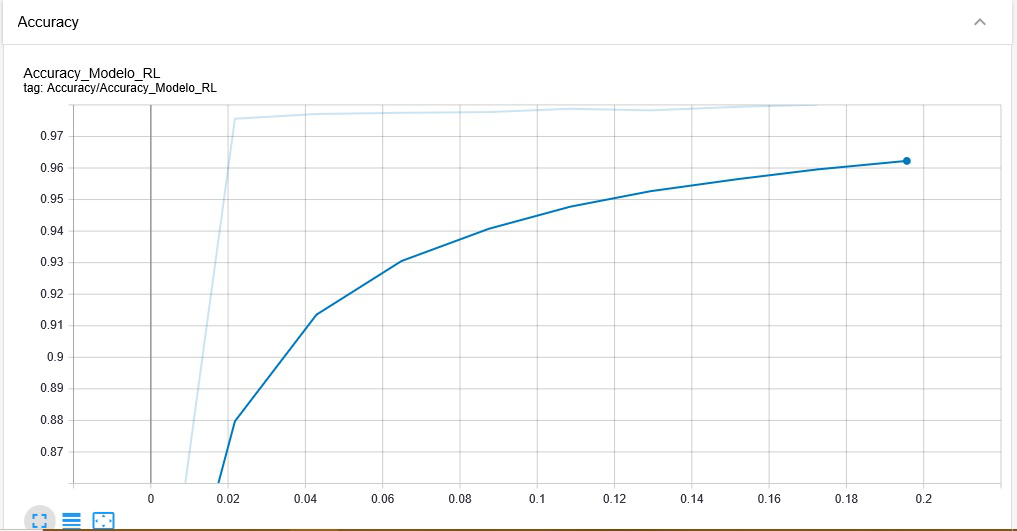

In [39]:
Image.open('Scalar 1 Tarea 4 RL.jpg','r') 

### Scalar Costo

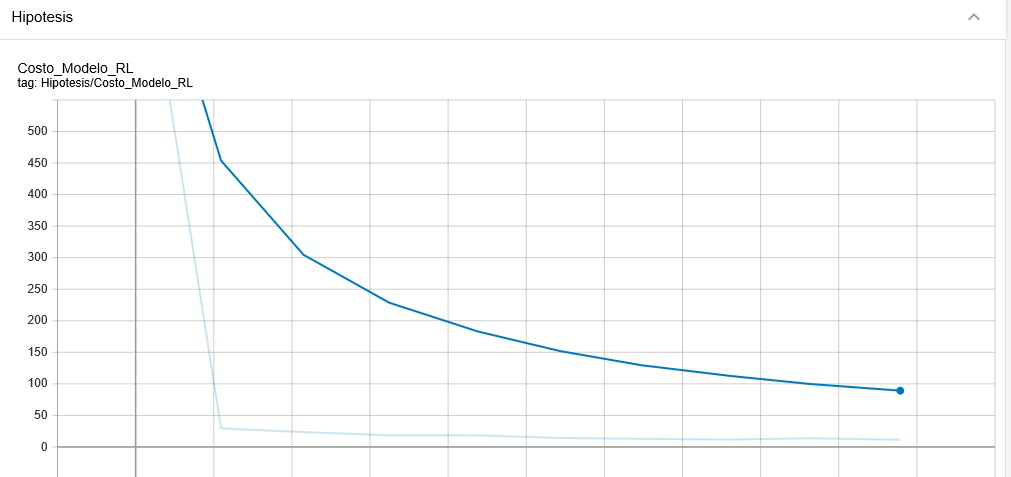

In [40]:
Image.open('Scalar 2 Tarea 4 RL.jpg','r') 

## Modelo en Tensorflow con Datos Normalizados

In [22]:
train_imagesN = (train_images - np.mean(train_images)) / (np.max(train_images)-np.min(train_images))

In [23]:
train_labelsN = (train_labels - np.mean(train_labels)) / (np.max(train_labels)-np.min(train_labels))

In [24]:
test_imagesN = (test_images - np.mean(test_images)) / (np.max(test_images)-np.min(test_images))

In [25]:
test_labelsN = (test_labels - np.mean(test_labels)) / (np.max(test_labels)-np.min(test_labels))

In [26]:
#Dataset Train

filtroN = (train_labels == 1) + (train_labels == 3) + (train_labels == 9) 

In [27]:
images_filtroTN = train_imagesN[filtroN]

## Preparando el Dataset Train

In [28]:
m = len(images_filtroTN)

In [29]:
shapeTN = np.shape(images_filtroTN)

In [30]:
imagesTN = images_filtroTN.reshape((m, -1))

## Preparando el Dataset Test

In [31]:
#Dataset Test

filtroTestN = (test_labels == 1) + (test_labels == 3) + (test_labels == 9) 

In [32]:
images_filtroTestM = test_images[filtroTestN]
m2 = len(images_filtroTest)

imagesTestN = images_filtroTest.reshape((m2, -1))

## Modelo en Tensorflow con Datos Normales

In [35]:
def images_predict(vector_imagen, lr, epochs, one_hot, matriz_X, matriz_test, hotTest):
    
    tf.reset_default_graph()
    g = tf.Graph()
    
    n = len(matriz_X)
    shapeT = np.shape(matriz_X)
    batch_size = 32
    total_iteraciones = int(n/batch_size)
    dic = {0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',
           4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag', 9:'Ankle boot'}
    dic2 = {0:'Trouser',1:'Dress',2:'Ankle boot'}


    with g.as_default():
   
        matriz_x = tf.placeholder(dtype=tf.float32, shape=[None,shapeT[1]], name = "matriz_x")
        matriz_w = tf.get_variable(dtype=tf.float32, initializer=tf.truncated_normal,shape=[shapeT[1],3], name = "matriz_w")
        intercepto = tf.get_variable(dtype=tf.float32, shape=[3], initializer=tf.zeros_initializer(), name="Intercepto")
        m_OneHot = tf.placeholder(dtype=tf.float32, shape=[None,3], name = "matriz_one_hot")
        m_OneHotTest = tf.placeholder(dtype=tf.float32, shape=[None,3])

    
        with tf.name_scope("Hipotesis"):
            logit = tf.matmul(matriz_x, matriz_w, name = "Logit") + intercepto
            costo = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logit, labels = m_OneHot), name = "Costo")
            scalar_costo = tf.summary.scalar('Costo Modelo RL', costo)

    
        with tf.name_scope("Gradiente"):
            gradiente = tf.gradients(costo, [matriz_w], name = "Gradient")
            gradiente2 = gradiente[0]
    

        with tf.name_scope("Parametros"):
            w_actual = tf.add(tf.multiply(gradiente2, -lr), matriz_w)
            matriz_w = matriz_w.assign(w_actual)
    
    
        prediccionT = tf.nn.softmax(logit, name = "Prediccion")
    
        with tf.name_scope("Accuracy"):
            a = tf.reshape(tf.math.argmax(prediccionT, axis = 1), shape = (1,-1))
            aa = tf.math.equal(a, 0)
            bb = labelsT.reshape(1,-1) == 1
            cc = tf.math.equal(aa, bb)
            dd = tf.count_nonzero(tf.equal(cc, True), name = "Conteo_Aciertos")
            ac = dd / n
            scalar_ac = tf.summary.scalar('Accuracy Modelo RL', ac)
        
        with tf.train.MonitoredSession() as session:
            
            writer = tf.summary.FileWriter('./graphs4', session.graph)

            for i in range(epochs):
    
                feed_dict = {matriz_x: matriz_X, m_OneHot: one_hot}
                print(session.run(costo, feed_dict = feed_dict))
                session.run(logit, feed_dict = feed_dict)
                sc = session.run(scalar_costo,feed_dict=feed_dict)
                writer.add_summary(sc, epochs+1)
                
                session.run(a, feed_dict = feed_dict)
                session.run(aa, feed_dict = feed_dict)
                session.run(ac, feed_dict = feed_dict)
                sa = session.run(scalar_ac,feed_dict=feed_dict)
                writer.add_summary(sa, epochs+1)

                
        
                for j in range(total_iteraciones):   
                    muestra_inicio = j*batch_size
                    muestra_fin = muestra_inicio + batch_size
                    X =  matriz_X[muestra_inicio:muestra_fin]
                    hot = one_hot[muestra_inicio:muestra_fin]
      
                    feed_dict2 = {matriz_x: X, m_OneHot: hot}
                    session.run(gradiente, feed_dict = feed_dict2)
                    session.run(w_actual, feed_dict = feed_dict2)
                    session.run(matriz_w, feed_dict = feed_dict2)
                    
                
                    p = session.run(prediccionT, feed_dict = feed_dict)
            
            
            feed_dict3 = {matriz_x: vector_imagen, m_OneHot: hotTest}
            session.run(costo, feed_dict = feed_dict3)
            session.run(logit, feed_dict = feed_dict3)
            predict = session.run(prediccionT, feed_dict = feed_dict3)
            num = np.argmax(predict)
            namePredict = dic2[num]
            
            
            plt.imshow(vector_imagen.reshape(28,28), cmap='gray')
            plt.xlabel(namePredict)
            plt.show()
            
            print("Accuracy:")
            print(session.run(ac, feed_dict = feed_dict))

            return(ac, predict, namePredict)
        
            

## Muestra de 5 Prendas

INFO:tensorflow:Summary name Costo Modelo RL is illegal; using Costo_Modelo_RL instead.
INFO:tensorflow:Summary name Accuracy Modelo RL is illegal; using Accuracy_Modelo_RL instead.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
13.94937
3.7714686
2.252287
1.6668692
1.3069284
1.0619681
0.8877706
0.7609644
0.6666265
0.59471554


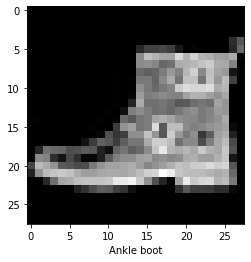

Accuracy:
0.8952222222222223


(<tf.Tensor 'Accuracy/truediv:0' shape=() dtype=float64>,
 array([[0., 0., 1.]], dtype=float32),
 'Ankle boot')

In [36]:
images_predict(imagesTestN[2748].reshape((1,784)), 0.001, 10, oneHotT, imagesTN, imagesTestN, oneHotTest)

INFO:tensorflow:Summary name Costo Modelo RL is illegal; using Costo_Modelo_RL instead.
INFO:tensorflow:Summary name Accuracy Modelo RL is illegal; using Accuracy_Modelo_RL instead.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
17.73523
0.39438054
0.25055745
0.19991659
0.1746829


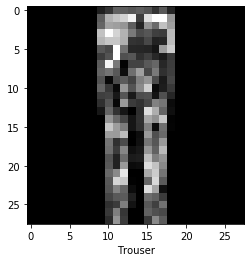

Accuracy:
0.9646111111111112


(<tf.Tensor 'Accuracy/truediv:0' shape=() dtype=float64>,
 array([[1., 0., 0.]], dtype=float32),
 'Trouser')

In [70]:
images_predict(imagesTestN[2998].reshape((1,784)), 0.01, 5, oneHotT, imagesTN, imagesTestN, oneHotTest)

INFO:tensorflow:Summary name Costo Modelo RL is illegal; using Costo_Modelo_RL instead.
INFO:tensorflow:Summary name Accuracy Modelo RL is illegal; using Accuracy_Modelo_RL instead.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
13.125033
4.2744107
1.66941
1.0646391
0.78839064


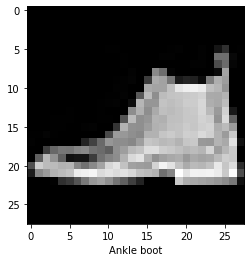

Accuracy:
0.8412222222222223


(<tf.Tensor 'Accuracy/truediv:0' shape=() dtype=float64>,
 array([[0., 0., 1.]], dtype=float32),
 'Ankle boot')

In [71]:
images_predict(imagesTestN[527].reshape((1,784)), 0.001, 5, oneHotT, imagesTN, imagesTestN, oneHotTest)

INFO:tensorflow:Summary name Costo Modelo RL is illegal; using Costo_Modelo_RL instead.
INFO:tensorflow:Summary name Accuracy Modelo RL is illegal; using Accuracy_Modelo_RL instead.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
3.2138767
1.625071
1.1514896
0.8780297
0.70619446


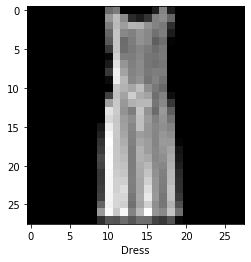

Accuracy:
0.8612777777777778


(<tf.Tensor 'Accuracy/truediv:0' shape=() dtype=float64>,
 array([[0., 1., 0.]], dtype=float32),
 'Dress')

In [72]:
images_predict(imagesTestN[400].reshape((1,784)), 0.001, 5, oneHotT, imagesTN, imagesTestN, oneHotTest)

INFO:tensorflow:Summary name Costo Modelo RL is illegal; using Costo_Modelo_RL instead.
INFO:tensorflow:Summary name Accuracy Modelo RL is illegal; using Accuracy_Modelo_RL instead.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
4.9210625
2.4815438
1.559852
1.1067402
0.86743045


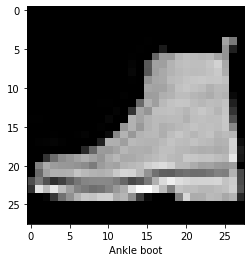

Accuracy:
0.8334444444444444


(<tf.Tensor 'Accuracy/truediv:0' shape=() dtype=float64>,
 array([[0., 0., 1.]], dtype=float32),
 'Ankle boot')

In [73]:
images_predict(imagesTestN[179].reshape((1,784)), 0.001, 5, oneHotT, imagesTN, imagesTestN, oneHotTest)

## Tensorboard

### Grafo

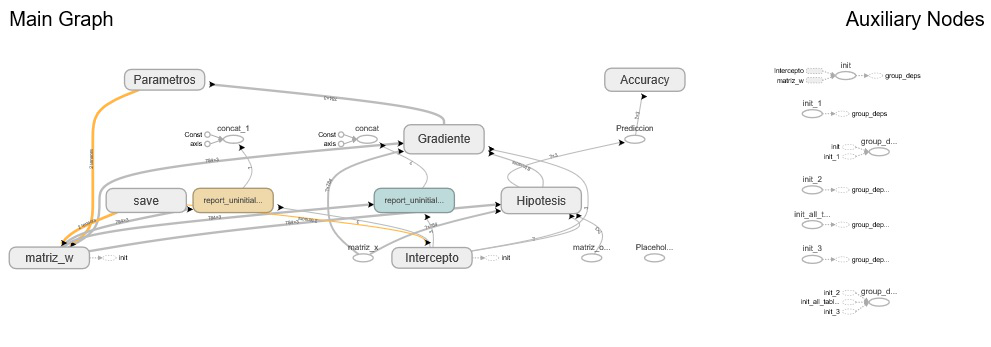

In [41]:
Image.open('Grafo 1 Tarea 4 RL.jpg','r') 

### Scalar Accuracy

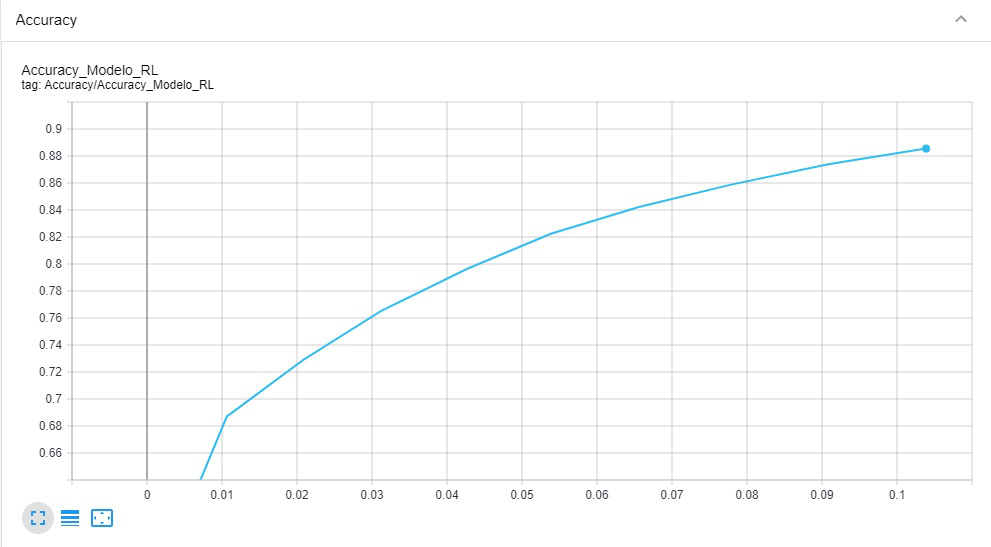

In [46]:
Image.open('Scalar 3 Tarea 4 RL.jpg','r') 

### Scalar Costo

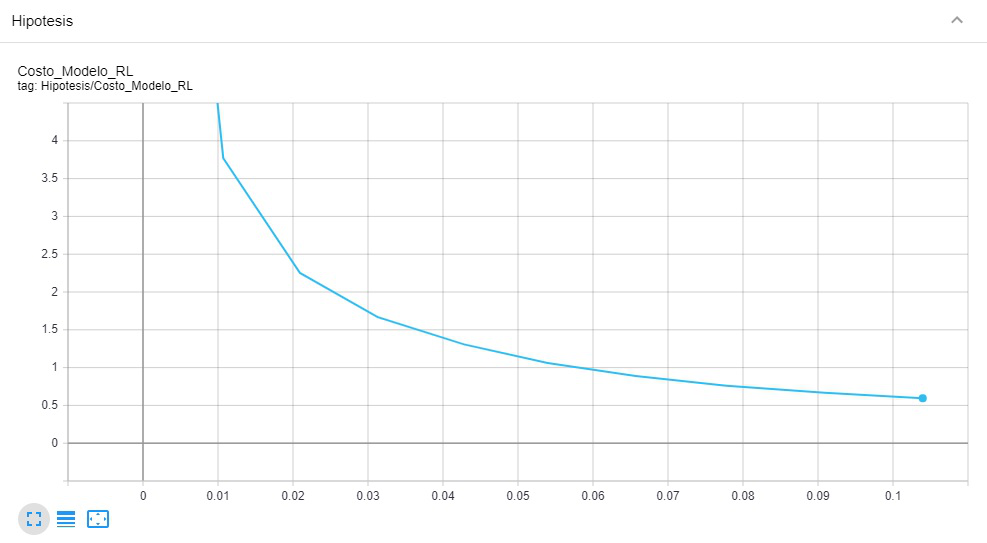

In [47]:
Image.open('Scalar 4 Tarea 4 RL.jpg','r') 

## Conclusiones

Luego de utilizar el modelo de Regresión Logística tanto para datos crudos como transformados se obtuvieron los siguientes resultados con los datos entrenados:

* El costo para datos crudos fue alrededor de 100
* El accuracy para datos crudos fue alrededor de 96%
* El costo para datos normalizados fue alrededor de 0.5
* El accuracy para datos normalizados fue alrededor de 88%

Puede verse una notoria mejoría, bastante significativa, en cuanto a la reducción de la función costo si se utilizan datos normalizados en lugar de crudos. En cuanto al accuracy si se ve reducido en un 8% al usar datos normalizados; sin embargo, aún se conserva en un buen nivel exactitud el modelo.

Basándose en estos resultados se puede concluir que es mejor utilizar el modelo con datos normalizados ya que la función de costo es mucho menor y se logra un nivel muy bueno de accuracy, por lo que el modelo es bueno prediciendo.

In [528]:
tf.reset_default_graph()
g = tf.Graph()

lr = 0.01
batch_size = 3000
epochs = 5
total_iteraciones = int(n/batch_size)
dic = {0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag', 9:'Ankle boot'}
dic2 = {0:'Trouser',1:'Dress',2:'Ankle boot'}

p2 = np.empty(shape=(n,3)) 

with g.as_default():
   
    matriz_x = tf.placeholder(dtype=tf.float32, shape=[None,shapeT[1]*shapeT[2]], name = "matriz_x")
    matriz_w = tf.get_variable(dtype=tf.float32, initializer=tf.truncated_normal(shape=[shapeT[1]*shapeT[2],3]), name = "matriz_w")
    intercepto = tf.get_variable(dtype=tf.float32, shape=[3], initializer=tf.zeros_initializer(), name="Intercepto")
    m_OneHot = tf.placeholder(dtype=tf.float32, shape=[None,3], name = "matriz_one_hot")

    
        # Logits
        #with tf.name_scope("Hipotesis"):
    logit = tf.matmul(matriz_x, matriz_w) + intercepto
    costo = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logit, labels = m_OneHot))
    

    
 # gradiente
        #with tf.name_scope("Gradiente"):
    gradiente = tf.gradients(costo, [matriz_w])
    gradiente2 = gradiente[0]
    

        # actualizacion de parametros
        #with tf.name_scope("Parametros"):
    w_actual = tf.add(tf.multiply(gradiente2, -lr), matriz_w)
    matriz_w = matriz_w.assign(w_actual)
    
    #Prediccion
    prediccionT = tf.nn.softmax(logit)
    
    #acuracy
    a = tf.reshape(tf.math.argmax(prediccionT, axis = 1), shape = (1,-1))
    aa = tf.math.equal(a, 0)
    bb = labelsT.reshape(1,-1) == 1
    cc = tf.math.equal(aa, bb)
        
        


    with tf.train.MonitoredSession() as session:

        
        for i in range(epochs):
    #shuffle(x,y) # buena practica (ordenar aleatoriamente)
    
            feed_dict = {matriz_x: imagesT, m_OneHot: oneHotT}
            session.run(costo, feed_dict = feed_dict)
            session.run(logit, feed_dict = feed_dict)

        
            for j in range(total_iteraciones):  #muchas iteraciones por epoch 
                muestra_inicio = j*batch_size
                muestra_fin = muestra_inicio + batch_size
                X =  imagesT[muestra_inicio:muestra_fin]
                hot = oneHotT[muestra_inicio:muestra_fin]
      
                feed_dict2 = {matriz_x: X, m_OneHot: hot}
                session.run(gradiente, feed_dict = feed_dict2)
                session.run(w_actual, feed_dict = feed_dict2)
                session.run(matriz_w, feed_dict = feed_dict2)
        
                
                p = session.run(prediccionT, feed_dict = feed_dict)
            
        print(np.shape(session.run(a, feed_dict = feed_dict)))
        print(np.shape(session.run(aa, feed_dict = feed_dict)))
        cc = session.run(cc, feed_dict = feed_dict)

        #a = np.argmax(p, axis = 1)
        #aa = a.reshape(1,-1) == 0
        #bb = labelsT.reshape(1,-1) == 1
        #cc = aa == bb
        ac = len(cc[cc == 1]) / n
        print(ac)
        
            

            #print(np.shape(session.run(logit, feed_dict = feed_dict)))
            #print(session.run(matriz_w, feed_dict = feed_dict))
            #print(session.run(prediccionT, feed_dict = feed_dict))

    

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
(1, 18000)
(1, 18000)
0.9714444444444444


In [652]:
tf.reset_default_graph()
g = tf.Graph()

lr = 0.1
batch_size = 3000
epochs = 5
total_iteraciones = int(n/batch_size)
dic = {0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag', 9:'Ankle boot'}
p2 = np.empty(shape=(n,3)) 

with g.as_default():
   
    matriz_x = tf.placeholder(dtype=tf.float32, shape=[n,shapeT[1]*shapeT[2]], name = "matriz_x")
    matriz_w = tf.get_variable(dtype=tf.float32, initializer=tf.truncated_normal(shape=[shapeT[1]*shapeT[2],3]), name = "matriz_w")
    intercepto = tf.get_variable(dtype=tf.float32, shape=[3], initializer=tf.zeros_initializer(), name="Intercepto")
    m_OneHot = tf.placeholder(dtype=tf.float32, shape=[n,3], name = "matriz_one_hot")

    
        # Logits
        #with tf.name_scope("Hipotesis"):
    logit = tf.matmul(matriz_x, matriz_w) + intercepto
    costo = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logit, labels = m_OneHot))
    
    
 # gradiente
        #with tf.name_scope("Gradiente"):
    gradiente = tf.gradients(costo, [matriz_w])
    gradiente2 = gradiente[0]
    

        # actualizacion de parametros
        #with tf.name_scope("Parametros"):
    w_actual = tf.add(tf.multiply(gradiente2, -lr), matriz_w)
    matriz_w = matriz_w.assign(w_actual)
    
    #Prediccion
    prediccionT = tf.nn.softmax(logit)


    with tf.train.MonitoredSession() as session:

        
        for i in range(epochs):
    #shuffle(x,y) # buena practica (ordenar aleatoriamente)
    
            feed_dict = {matriz_x: imagesT, m_OneHot: oneHotT}
            session.run(costo, feed_dict = feed_dict)
            print("logit")
            print(np.shape(session.run(logit, feed_dict = feed_dict)))

            #feed_dict2 = {matriz_x: X, m_OneHot: hot}
            session.run(gradiente[0], feed_dict = feed_dict)
            session.run(w_actual, feed_dict = feed_dict)
            session.run(matriz_w, feed_dict = feed_dict)
            
        
            print("prediccion")
            print(np.shape(session.run(prediccionT, feed_dict = feed_dict)))


        
        
            

            #print(np.shape(session.run(logit, feed_dict = feed_dict)))
            #print(session.run(matriz_w, feed_dict = feed_dict))
            #print(session.run(prediccionT, feed_dict = feed_dict))

    

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
logit
(18000, 3)
prediccion
(18000, 3)
logit
(18000, 3)
prediccion
(18000, 3)
logit
(18000, 3)
prediccion
(18000, 3)
logit
(18000, 3)
prediccion
(18000, 3)
logit
(18000, 3)
prediccion
(18000, 3)
